In [1]:
using FEM, Potential, AlphaBeta, PyPlot, Printf, PhotonOperator, JLD, LinearAlgebra

### Part 1: Get collocation points and integration kernel for whole domain

In [2]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration
Nv = 72    # Number of eigenvectors

# Define Physical Domain
xratio = 64. # unit: angstrom
xavg = 0.   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V(x)$ and $p_{\rm eq}(x)$

In [3]:
sigma_kref = 8.
kref = get_k_by_sigma(sigma_kref)
Vref = harmonic_well_k_mean(xref, kref, xavg)
rho_eq = get_rhoeq(Vref, w0)
p_eq = rho_eq .* rho_eq;

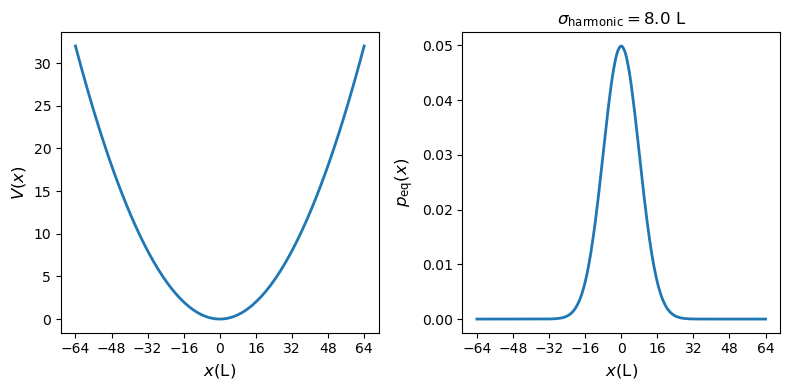

In [4]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,4))

ax = axes[1]
ax.plot(xref, Vref, linewidth=2)
ax.set_xlabel("\$x\$(L)", fontsize=12)
ax.set_ylabel("\$V(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)
#ax.set_ylim(0, 10)

ax = axes[2]
ax.plot(xref, p_eq, linewidth=2)
ax.set_xlabel("\$x\$(L)", fontsize=12)
ax.set_ylabel("\$p_{\\rm eq}(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)
ax.set_title(@sprintf "\$\\sigma_{\\rm harmonic} = %.1f\$ L" sigma_kref)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/0/harmonic_well_r.svg")
plt.show()

### Part 3: Set parameters about simulations

In [4]:
# physical parameters
save_freq = 1e-2 # unit: s, Save trajectory per 1e-2 s
total_times = 100 # unit: s, totol simulate 100 s
dt = 2e-5 # unit: s  # Integration Times 1ps
D = 500; # Diffusion coefficient, unit: s-1
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 500 timesteps. There will be 10000 data points.


In [5]:
# Read simulated trajectory from jld file
f_in = "/home/yizaochen/codes/julia/md_pisl/trajectory/harmonic_well_r_0.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
k_ref = load(f_in, "k_ref")
D = load(f_in, "D");

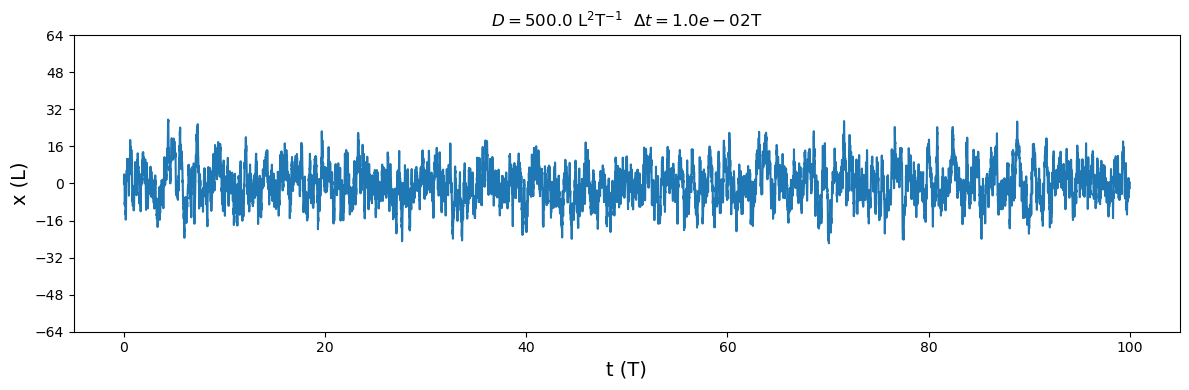

In [9]:
lbfz = 14
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,4))

ax.plot(t_record, y_record)
ax.set_ylabel("x (L)", fontsize=lbfz)
ax.set_xlabel("t (T)", fontsize=lbfz)
ax.set_title(@sprintf "\$ D=%.1f\$ L\$^{2}\$T\$^{-1}\$  \$\\Delta t=%.1e\$T " D save_freq)
ax.set_yticks(-64:16:64)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/0/reduced_traj.svg")
plt.show()

### Part 4-1: FEM to get eigenvector and eigenvalues for normal D

In [6]:
eigenvalues, eigenvect_mat, rho_eq_by_fem = fem_solve_eigen_by_pref(Nh, Np, xratio, xavg, p_eq, D, Nv)
weight_Qx = get_weight_Qx(N, Nv, w0, eigenvect_mat);

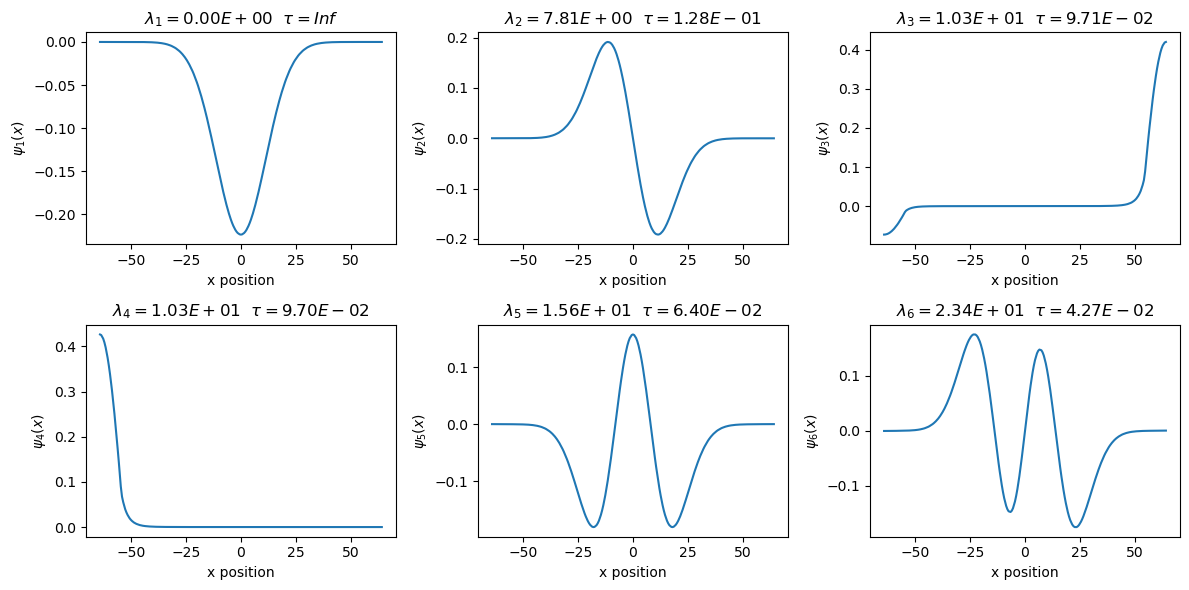

In [18]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12,6))

idx_eigvector = 1
for row_id = 1:2
    for col_id = 1:3
        plot_x_Qx_lambda(axes[row_id, col_id], idx_eigvector, eigenvalues, eigenvect_mat, xref)
        idx_eigvector += 1
        #axes[row_id, col_id].set_ylim(-0.4, 0.4)
    end
end

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/distance_dependent_D.pdf")
plt.show()

### Part 4-2: FEM to get eigenvector and eigenvalues when $D=1$

In [7]:
D_test = 1e0
eigenvalues_prime, eigenvect_mat_prime, rho_eq_by_fem_prime = fem_solve_eigen_by_pref(Nh, Np, xratio, xavg, p_eq, D_test, Nv)
weight_Qx_prime = get_weight_Qx(N, Nv, w0, eigenvect_mat_prime);

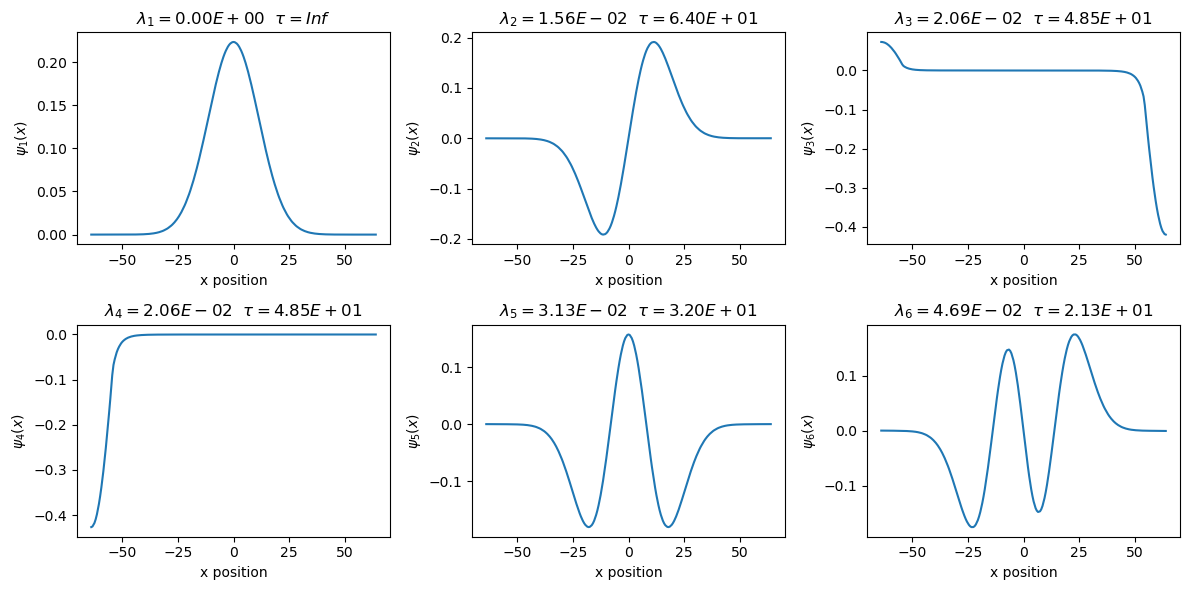

In [46]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12,6))

idx_eigvector = 1
for row_id = 1:2
    for col_id = 1:3
        plot_x_Qx_lambda(axes[row_id, col_id], idx_eigvector, eigenvalues, eigenvect_mat, xref)
        idx_eigvector += 1
        #axes[row_id, col_id].set_ylim(-0.4, 0.4)
    end
end

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/distance_dependent_D.pdf")
plt.show()

### Part 4-3: Initialize $e^{-\textbf{H}\Delta t}$

In [8]:
D_guess = 500
expLQDT = exp.(-(D_guess * eigenvalues_prime) .* save_freq);

### Part 5: Set Photon $\sigma$

In [9]:
σ_delta = 2.0
k_delta = get_k_by_sigma(σ_delta);

### Part 6: Get all normalization constant from $\alpha$

In [14]:
time_idx = 5
idx = find_nearest_point(y_record[time_idx], xref, e_norm, interpo_xs, Np)
p_y5 = get_gaussian(k_delta, xref, idx)
p_y5 = p_y5 / sum(w0 .* p_y5);

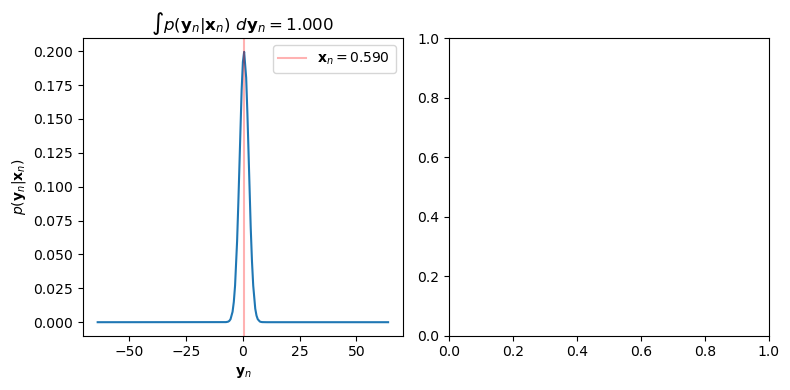

In [17]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,4))

ax = axes[1]
ax.plot(xref, p_y5)
label = @sprintf "\$ \\mathbf{x}_n=%.3f\$" y_record[time_idx]
ax.axvline(y_record[time_idx], color="red", label=label, alpha=0.3)
ax.set_ylabel("\$p(\\mathbf{y}_n|\\mathbf{x}_n)\$")
ax.set_xlabel("\$\\mathbf{y}_n\$")
title = @sprintf "\$ \\int p(\\mathbf{y}_n|\\mathbf{x}_n) ~d\\mathbf{y}_n=%.3f \$" sum(p_y5 .* w0)
ax.set_title(title)
ax.legend()

plt.tight_layout()
#plt.savefig("/home/ytcdata/em_theory/Pictures/ch8/gamma5_example.pdf")
plt.show()

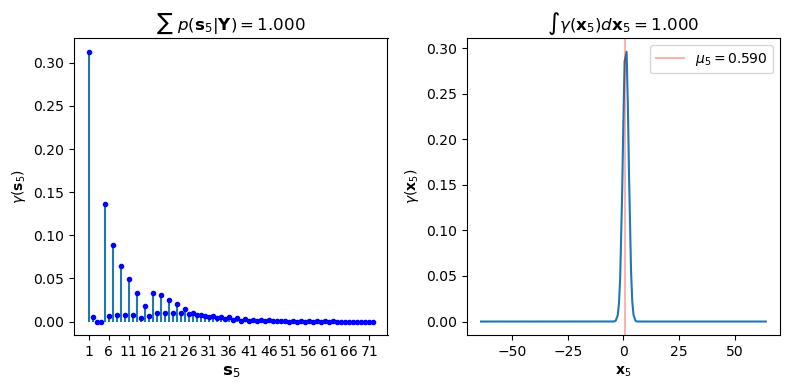

In [123]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,4))

ax = axes[1]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, gamma_s5, "b.")
ax.vlines(xarray, ymin=0, ymax=gamma_s5)
ax.set_xlabel("\$\\mathbf{s}_5\$", fontsize=12)
ax.set_ylabel("\$\\gamma(\\mathbf{s}_5)\$")
ax.set_xticks(xticks)
title = @sprintf "\$\\sum~p(\\mathbf{s}_5|\\mathbf{Y})=%.3f \$" sum(gamma_s5)
ax.set_title(title)

ax = axes[2]
ax.plot(xref, gamma_x5)
label = @sprintf "\$ \\mu_{%d}=%.3f\$" time_idx y_record[time_idx]
ax.axvline(y_record[time_idx], color="red", label=label, alpha=0.3)
ax.set_ylabel("\$\\gamma(\\mathbf{x}_5)\$")
ax.set_xlabel("\$\\mathbf{x}_5\$")
title = @sprintf "\$ \\int \\gamma(\\mathbf{x}_5) d\\mathbf{x}_5=%.3f \$" sum(gamma_x5 .* w0)
ax.set_title(title)
ax.legend()

plt.tight_layout()
#plt.savefig("/home/ytcdata/em_theory/Pictures/ch8/gamma5_example.pdf")
plt.show()

### Part 8-1: $p(\textbf{y}_5|\textbf{s}_5)$

In [138]:
idx = find_nearest_point(y_record[5], xref, e_norm, interpo_xs, Np)
p_y5 = get_gaussian(k_delta, xref, idx)
p_y5 = p_y5 / sum(w0 .* p_y5)

rho_y5 = sqrt.(p_y5);

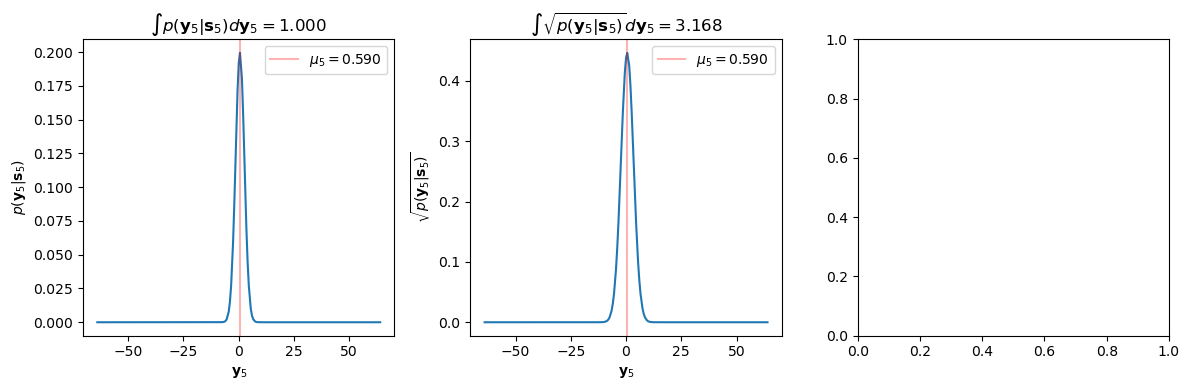

In [139]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, p_y5)
label = @sprintf "\$ \\mu_{%d}=%.3f\$" time_idx y_record[5]
ax.axvline(y_record[time_idx], color="red", label=label, alpha=0.3)
ax.set_ylabel("\$p(\\mathbf{y}_5|\\mathbf{s}_5)\$")
ax.set_xlabel("\$\\mathbf{y}_5\$")
title = @sprintf "\$ \\int p(\\mathbf{y}_5|\\mathbf{s}_5) d\\mathbf{y}_5=%.3f \$" sum(p_y5 .* w0)
ax.set_title(title)
ax.legend()

ax = axes[2]
ax.plot(xref, rho_y5)
label = @sprintf "\$ \\mu_{%d}=%.3f\$" time_idx y_record[5]
ax.axvline(y_record[time_idx], color="red", label=label, alpha=0.3)
ax.set_ylabel("\$\\sqrt{p(\\mathbf{y}_5|\\mathbf{s}_5)}\$")
ax.set_xlabel("\$\\mathbf{y}_5\$")
title = @sprintf "\$ \\int \\sqrt{p(\\mathbf{y}_5|\\mathbf{s}_5)} d\\mathbf{y}_5=%.3f \$" sum(rho_y5 .* w0)
ax.set_title(title)
ax.legend()


plt.tight_layout()
#plt.savefig("/home/ytcdata/em_theory/Pictures/ch8/gamma5_example.pdf")
plt.show()

In [148]:
p_y5_by_bra = proj_vector_from_eigenspace_to_xspace(eigenvect_mat, y_beta_s5) .^ 2;

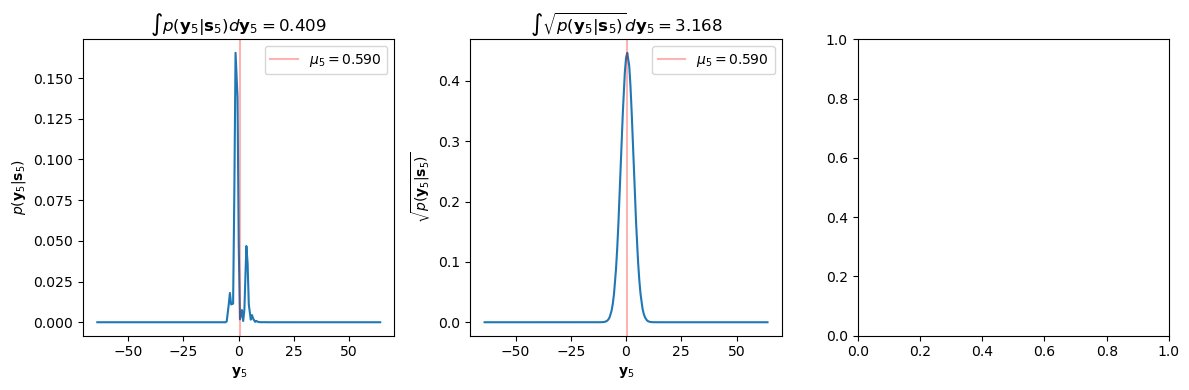

In [149]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, p_y5_by_bra)
label = @sprintf "\$ \\mu_{%d}=%.3f\$" time_idx y_record[5]
ax.axvline(y_record[time_idx], color="red", label=label, alpha=0.3)
ax.set_ylabel("\$p(\\mathbf{y}_5|\\mathbf{s}_5)\$")
ax.set_xlabel("\$\\mathbf{y}_5\$")
title = @sprintf "\$ \\int p(\\mathbf{y}_5|\\mathbf{s}_5) d\\mathbf{y}_5=%.3f \$" sum(p_y5_by_bra .* w0)
ax.set_title(title)
ax.legend()

ax = axes[2]
ax.plot(xref, rho_y5)
label = @sprintf "\$ \\mu_{%d}=%.3f\$" time_idx y_record[5]
ax.axvline(y_record[time_idx], color="red", label=label, alpha=0.3)
ax.set_ylabel("\$\\sqrt{p(\\mathbf{y}_5|\\mathbf{s}_5)}\$")
ax.set_xlabel("\$\\mathbf{y}_5\$")
title = @sprintf "\$ \\int \\sqrt{p(\\mathbf{y}_5|\\mathbf{s}_5)} d\\mathbf{y}_5=%.3f \$" sum(rho_y5 .* w0)
ax.set_title(title)
ax.legend()


plt.tight_layout()
#plt.savefig("/home/ytcdata/em_theory/Pictures/ch8/gamma5_example.pdf")
plt.show()

### Part 8-2: $\beta(\textbf{s}_4)$

$e^{-\textbf{H}\Delta t}\textbf{y}_{5}\left| \hat{\beta}_{5} \right>$

In [147]:
time_idx = 5
photon_mat = get_photon_matrix_gaussian(y_record[time_idx], xref, e_norm, interpo_xs, Np, w0, k_delta)
photon_mat = sqrt.(photon_mat)
psi_photon_psi = eigenvect_mat' * photon_mat * eigenvect_mat

y_beta_s5 = psi_photon_psi * beta_s5
#edt_y_beta_s5 = expLQDT .* y_beta_s5;
#edt_y_beta_s5[1] = sign(edt_y_beta_s5[1]) * sqrt(dot(y_beta_s5, y_beta_s5) - sum((edt_y_beta_s5[2:end]).^2));

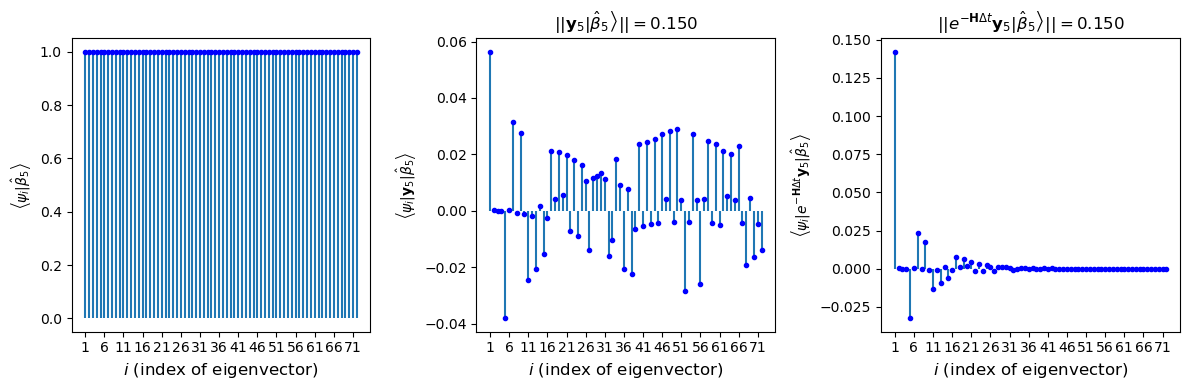

In [124]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

ax = axes[1]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, beta_5_bra, "b.")
ax.vlines(xarray, ymin=0, ymax=beta_5_bra)
ax.set_xlabel("\$i\$ (index of eigenvector)", fontsize=12)
ax.set_ylabel("\$\\left< \\psi_i | \\hat{\\beta}_5 \\right>\$")
ax.set_xticks(xticks)

ax = axes[2]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, y_beta_s5, "b.")
ax.vlines(xarray, ymin=0, ymax=y_beta_s5)
ax.set_xlabel("\$i\$ (index of eigenvector)", fontsize=12)
ax.set_ylabel("\$\\left< \\psi_i | \\mathbf{y}_5 | \\hat{\\beta}_5 \\right>\$")
ax.set_xticks(xticks)
title = @sprintf "\$|| \\mathbf{y}_5 \\left| \\hat{\\beta}_5 \\right> ||=%.3f \$" norm(y_beta_s5)
ax.set_title(title)

ax = axes[3]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, edt_y_beta_s5, "b.")
ax.vlines(xarray, ymin=0, ymax=edt_y_beta_s5)
ax.set_xlabel("\$i\$ (index of eigenvector)", fontsize=12)
ax.set_ylabel("\$\\left< \\psi_i | e^{-\\mathbf{H}\\Delta t}\\mathbf{y}_5 | \\hat{\\beta}_5 \\right>\$")
ax.set_xticks(xticks)
title = @sprintf "\$|| e^{-\\mathbf{H}\\Delta t} \\mathbf{y}_5 \\left| \\hat{\\beta}_5 \\right> ||=%.3f \$" norm(edt_y_beta_s5)
ax.set_title(title)


plt.tight_layout()
#plt.savefig("/home/ytcdata/em_theory/Pictures/ch8/y_beta5.pdf")
plt.show()

$\left| \hat{\beta}_4 \right> = \frac{e^{-\textbf{H}\Delta t}\textbf{y}_{5}\left| \hat{\beta}_{5} \right>}{\sqrt{c_5}}$

In [127]:
beta_hat_4_bra = edt_y_beta_s5 ./ Anorm_vec[time_idx];

$\gamma(\textbf{s}_4) = p(\textbf{s}_4| \textbf{Y}) = \hat{\alpha}(\textbf{s}_4)\hat{\beta}(\textbf{s}_4)$

In [128]:
alpha_s4 = alpha_mat[:,4] .^ 2
gamma_s4 = alpha_s4 .* beta_hat_4_bra

alpha_x4 = proj_vector_from_eigenspace_to_xspace(eigenvect_mat, alpha_mat[:,4]) .^ 2
beta_x4 = proj_vector_from_eigenspace_to_xspace(eigenvect_mat, beta_hat_4_bra) .^ 2
gamma_x4 = alpha_x4 .* beta_x4;

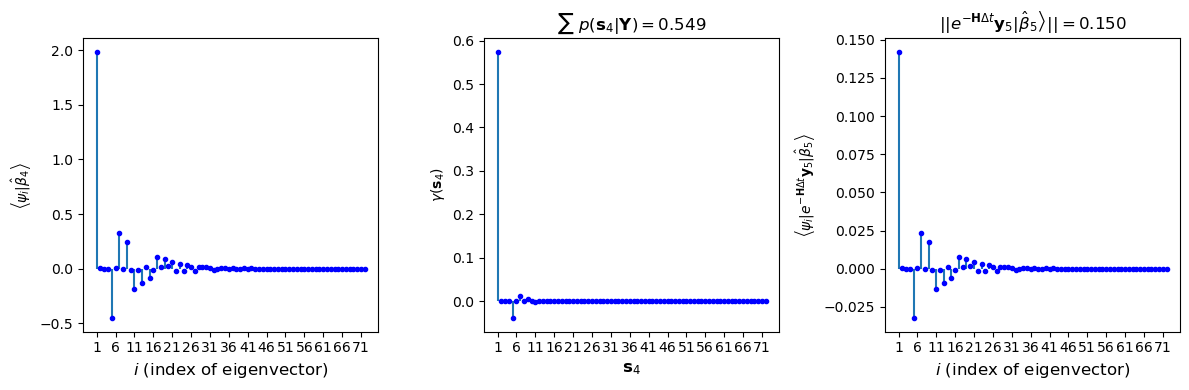

In [131]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

ax = axes[1]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, beta_hat_4_bra, "b.")
ax.vlines(xarray, ymin=0, ymax=beta_hat_4_bra)
ax.set_xlabel("\$i\$ (index of eigenvector)", fontsize=12)
ax.set_ylabel("\$\\left< \\psi_i | \\hat{\\beta}_4 \\right>\$")
ax.set_xticks(xticks)

ax = axes[2]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, gamma_s4, "b.")
ax.vlines(xarray, ymin=0, ymax=gamma_s4)
ax.set_xlabel("\$\\mathbf{s}_4\$", fontsize=12)
ax.set_ylabel("\$\\gamma(\\mathbf{s}_4)\$")
ax.set_xticks(xticks)
title = @sprintf "\$\\sum~p(\\mathbf{s}_4|\\mathbf{Y})=%.3f \$" sum(gamma_s4)
ax.set_title(title)

ax = axes[3]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, edt_y_beta_s5, "b.")
ax.vlines(xarray, ymin=0, ymax=edt_y_beta_s5)
ax.set_xlabel("\$i\$ (index of eigenvector)", fontsize=12)
ax.set_ylabel("\$\\left< \\psi_i | e^{-\\mathbf{H}\\Delta t}\\mathbf{y}_5 | \\hat{\\beta}_5 \\right>\$")
ax.set_xticks(xticks)
title = @sprintf "\$|| e^{-\\mathbf{H}\\Delta t} \\mathbf{y}_5 \\left| \\hat{\\beta}_5 \\right> ||=%.3f \$" norm(edt_y_beta_s5)
ax.set_title(title)

plt.tight_layout()
#plt.savefig("/home/ytcdata/em_theory/Pictures/ch8/pi_example.pdf")
plt.show()

### Part 6: $\alpha(\textbf{s}_1)$

$\left< \alpha_{1} \right| = \left< \rho_{1} \right| \textbf{y}_1$

In [47]:
time_idx = 1
photon_mat = get_photon_matrix_gaussian(y_record[time_idx], xref, e_norm, interpo_xs, Np, w0, k_delta)
psi_photon_psi = eigenvect_mat' * photon_mat * eigenvect_mat
alpha_1_bra = psi_photon_psi * rho_s1
alpha_s1 = alpha_1_bra .^ 2
alpha_x1 = proj_vector_from_eigenspace_to_xspace(eigenvect_mat, alpha_1_bra) .^ 2
c1 = sum(alpha_s1);

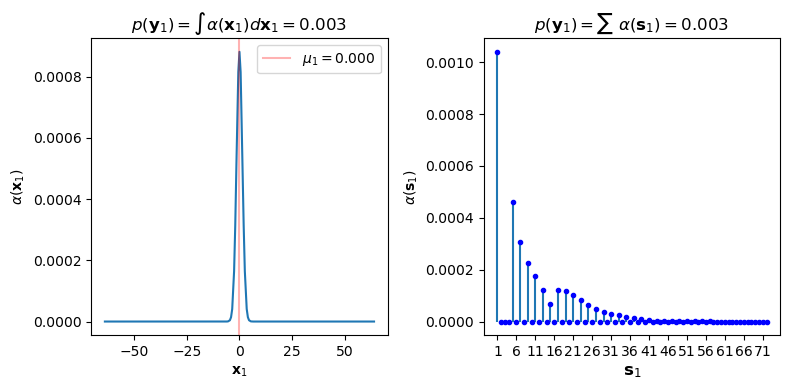

In [50]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,4))

ax = axes[1]
ax.plot(xref, alpha_x1)
label = @sprintf "\$ \\mu_{%d}=%.3f\$" time_idx y_record[time_idx]
ax.axvline(y_record[time_idx], color="red", label=label, alpha=0.3)
ax.set_ylabel("\$\\alpha(\\mathbf{x}_1)\$")
ax.set_xlabel("\$\\mathbf{x}_1\$")
title = @sprintf "\$ p(\\mathbf{y}_1)=\\int \\alpha(\\mathbf{x}_1) d\\mathbf{x}_1=%.3f \$" sum(alpha_x1 .* w0)
ax.set_title(title)
ax.legend()

ax = axes[2]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, alpha_s1, "b.")
ax.vlines(xarray, ymin=0, ymax=alpha_s1)
ax.set_xticks(xticks)
ax.set_xlabel("\$\\mathbf{s}_1 \$", fontsize=12)
ax.set_ylabel("\$\\alpha(\\mathbf{s}_1)\$")
title = @sprintf "\$ p(\\mathbf{y}_1)=\\sum~\\alpha(\\mathbf{s}_1)=%.3f \$" sum(alpha_s1)
ax.set_title(title)

plt.tight_layout()
#plt.savefig("/home/ytcdata/em_theory/Pictures/ch8/alpha1_example.pdf")
plt.show()

$\left< \hat{\alpha}_{1} \right| = \frac{\left< \alpha_{1} \right|}{\lvert\lvert \left< \alpha_{1} \right| \rvert\rvert}$

In [52]:
alpha_hat_1_bra = alpha_1_bra ./ sqrt(c1)
alpha_hat_s1 = alpha_hat_1_bra .^ 2
alpha_hat_x1 = proj_vector_from_eigenspace_to_xspace(eigenvect_mat, alpha_hat_1_bra) .^ 2;

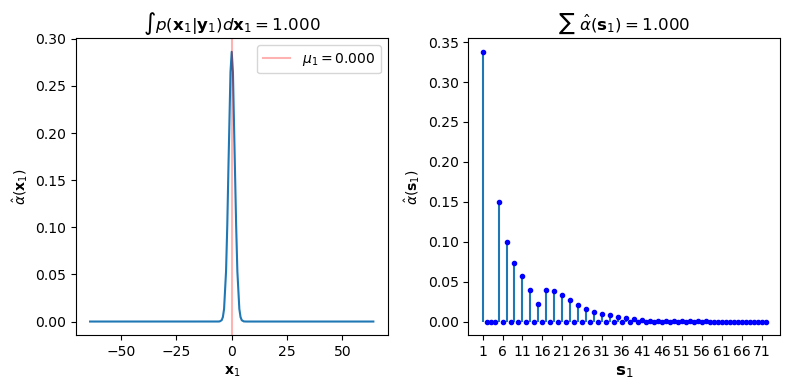

In [55]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,4))

ax = axes[1]
ax.plot(xref, alpha_hat_x1)
label = @sprintf "\$ \\mu_{%d}=%.3f\$" time_idx y_record[time_idx]
ax.axvline(y_record[time_idx], color="red", label=label, alpha=0.3)
ax.set_ylabel("\$\\hat{\\alpha}(\\mathbf{x}_1)\$")
ax.set_xlabel("\$\\mathbf{x}_1\$")
title = @sprintf "\$ \\int p(\\mathbf{x}_1|\\mathbf{y}_1) d\\mathbf{x}_1=%.3f \$" sum(alpha_hat_x1 .* w0)
ax.set_title(title)
ax.legend()

ax = axes[2]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, alpha_hat_s1, "b.")
ax.vlines(xarray, ymin=0, ymax=alpha_hat_s1)
ax.set_xticks(xticks)
ax.set_xlabel("\$\\mathbf{s}_1 \$", fontsize=12)
ax.set_ylabel("\$\\hat{\\alpha}(\\mathbf{s}_1)\$")
title = @sprintf "\$ \\sum~\\hat{\\alpha}(\\mathbf{s}_1)=%.3f \$" sum(alpha_hat_s1)
ax.set_title(title)

plt.tight_layout()
#plt.savefig("/home/ytcdata/em_theory/Pictures/ch8/alpha_hat_1_example.pdf")
plt.show()

### Part 6: $\alpha(\textbf{s}_1)$

$\left< \hat{\alpha}_{1} \right| e^{-\textbf{H}\Delta t}$

In [62]:
alpha_hat_1_e_delta_t_bra = expLQDT .* alpha_hat_1_bra
alpha_hat_1_e_delta_t_bra[1] = sign(alpha_hat_1_bra[1]) * sqrt(1 - sum((alpha_hat_1_e_delta_t_bra[2:end]).^2))
alpha_hat_s1_e_delta_t = alpha_hat_1_e_delta_t_bra .^ 2
alpha_hat_x1_e_delta_t = proj_vector_from_eigenspace_to_xspace(eigenvect_mat, alpha_hat_1_e_delta_t_bra) .^ 2;

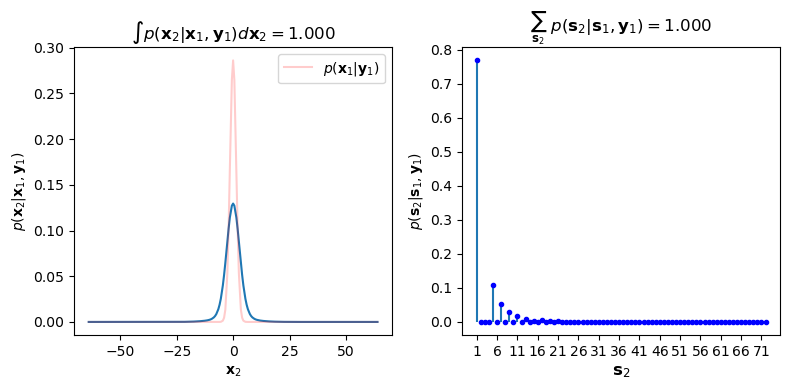

In [64]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,4))

ax = axes[1]
ax.plot(xref, alpha_hat_x1_e_delta_t)
ax.plot(xref, alpha_hat_x1, alpha=0.2, color="red", label="\$p(\\mathbf{x}_1|\\mathbf{y}_1)\$")
ax.set_ylabel("\$p(\\mathbf{x}_2|\\mathbf{x}_1,\\mathbf{y}_1)\$")
ax.set_xlabel("\$\\mathbf{x}_2\$")
title = @sprintf "\$ \\int p(\\mathbf{x}_2|\\mathbf{x}_1,\\mathbf{y}_1) d\\mathbf{x}_2=%.3f \$" sum(alpha_hat_x1_e_delta_t .* w0)
ax.set_title(title)
ax.legend()

ax = axes[2]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, alpha_hat_s1_e_delta_t, "b.")
ax.vlines(xarray, ymin=0, ymax=alpha_hat_s1_e_delta_t)
ax.set_xticks(xticks)
ax.set_xlabel("\$\\mathbf{s}_2 \$", fontsize=12)
ax.set_ylabel("\$p(\\mathbf{s}_2|\\mathbf{s}_1,\\mathbf{y}_1)\$")
title = @sprintf "\$ \\sum_{\\mathbf{s}_2}~p(\\mathbf{s}_2|\\mathbf{s}_1,\\mathbf{y}_1)=%.3f \$" sum(alpha_hat_s1_e_delta_t)
ax.set_title(title)

plt.tight_layout()
#plt.savefig("/home/ytcdata/em_theory/Pictures/ch8/alpha_hat_1_edt_example.pdf")
plt.show()

$\left< \hat{\alpha}_{1} \right| e^{-\textbf{H}\Delta t}\textbf{y}_2$

In [65]:
time_idx = 2
photon_mat = get_photon_matrix_gaussian(y_record[time_idx], xref, e_norm, interpo_xs, Np, w0, k_delta)
psi_photon_psi = eigenvect_mat' * photon_mat * eigenvect_mat

alpha_hat_1_e_delta_t_y_bra = psi_photon_psi * alpha_hat_1_e_delta_t_bra
alpha_hat_s1_e_delta_t_y_bra = alpha_hat_1_e_delta_t_y_bra .^ 2
alpha_hat_x1_e_delta_t_y_bra = proj_vector_from_eigenspace_to_xspace(eigenvect_mat, alpha_hat_1_e_delta_t_y_bra) .^ 2
c2 = sum(alpha_hat_s1_e_delta_t_y_bra);

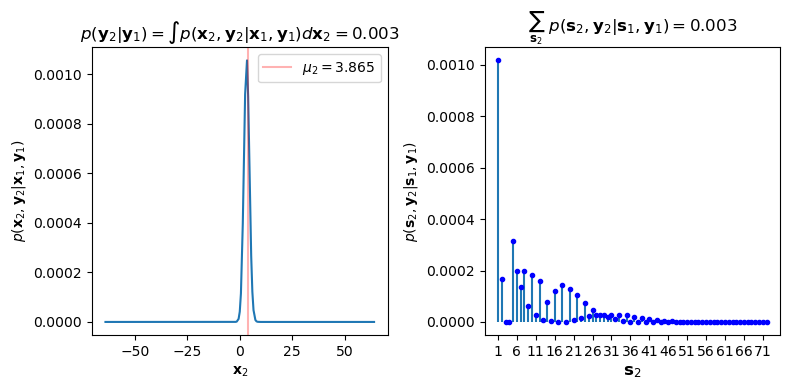

In [68]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,4))

ax = axes[1]
ax.plot(xref, alpha_hat_x1_e_delta_t_y_bra)
label = @sprintf "\$ \\mu_{%d}=%.3f\$" time_idx y_record[time_idx]
ax.axvline(y_record[time_idx], color="red", label=label, alpha=0.3)
ax.set_ylabel("\$p(\\mathbf{x}_2,\\mathbf{y}_2|\\mathbf{x}_1,\\mathbf{y}_1)\$")
ax.set_xlabel("\$\\mathbf{x}_2\$")
title = @sprintf "\$ p(\\mathbf{y}_2|\\mathbf{y}_1) = \\int p(\\mathbf{x}_2,\\mathbf{y}_2|\\mathbf{x}_1,\\mathbf{y}_1) d\\mathbf{x}_2=%.3f \$" sum(alpha_hat_x1_e_delta_t_y_bra .* w0)
ax.set_title(title)
ax.legend()

ax = axes[2]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, alpha_hat_s1_e_delta_t_y_bra, "b.")
ax.vlines(xarray, ymin=0, ymax=alpha_hat_s1_e_delta_t_y_bra)
ax.set_xticks(xticks)
ax.set_xlabel("\$\\mathbf{s}_2 \$", fontsize=12)
ax.set_ylabel("\$p(\\mathbf{s}_2,\\mathbf{y}_2|\\mathbf{s}_1,\\mathbf{y}_1)\$")
title = @sprintf "\$ \\sum_{\\mathbf{s}_2}~p(\\mathbf{s}_2,\\mathbf{y}_2|\\mathbf{s}_1,\\mathbf{y}_1)=%.3f \$" sum(alpha_hat_s1_e_delta_t_y_bra)
ax.set_title(title)

plt.tight_layout()
plt.savefig("/home/ytcdata/em_theory/Pictures/ch8/alpha_hat_1_edt_y2_example.pdf")
plt.show()

Normalization

In [69]:
alpha_hat_2_bra = alpha_hat_1_e_delta_t_y_bra ./ sqrt(c2)
alpha_hat_s2 = alpha_hat_2_bra .^ 2
alpha_hat_x2 = proj_vector_from_eigenspace_to_xspace(eigenvect_mat, alpha_hat_2_bra) .^ 2;

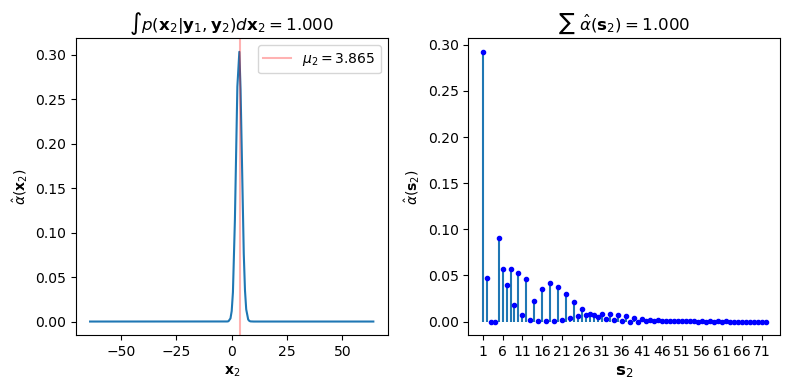

In [71]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,4))

ax = axes[1]
ax.plot(xref, alpha_hat_x2)
label = @sprintf "\$ \\mu_{%d}=%.3f\$" time_idx y_record[time_idx]
ax.axvline(y_record[time_idx], color="red", label=label, alpha=0.3)
ax.set_ylabel("\$\\hat{\\alpha}(\\mathbf{x}_2)\$")
ax.set_xlabel("\$\\mathbf{x}_2\$")
title = @sprintf "\$ \\int p(\\mathbf{x}_2|\\mathbf{y}_1,\\mathbf{y}_2) d\\mathbf{x}_2=%.3f \$" sum(alpha_hat_x2 .* w0)
ax.set_title(title)
ax.legend()

ax = axes[2]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, alpha_hat_s2, "b.")
ax.vlines(xarray, ymin=0, ymax=alpha_hat_s2)
ax.set_xticks(xticks)
ax.set_xlabel("\$\\mathbf{s}_2 \$", fontsize=12)
ax.set_ylabel("\$\\hat{\\alpha}(\\mathbf{s}_2)\$")
title = @sprintf "\$ \\sum~\\hat{\\alpha}(\\mathbf{s}_2)=%.3f \$" sum(alpha_hat_s2)
ax.set_title(title)

plt.tight_layout()
#plt.savefig("/home/ytcdata/em_theory/Pictures/ch8/alpha_hat_2_example.pdf")
plt.show()